#### Loading libraries and Configs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers,Model
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
DATA_DIR = '../data1/'
IMG_SIZE = 224
BATCH_SIZE = 32
IMG_COLOR_CHANNEL = 3
IMG_COLOR_MODE = "rgb"
NUM_EPOCHS = 150

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  color_mode=IMG_COLOR_MODE,
  seed=124,
  shuffle=True,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)
class_names = train_ds.class_names

Found 300 files belonging to 3 classes.
Using 240 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  color_mode=IMG_COLOR_MODE,
  seed=124,
  shuffle=True,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 300 files belonging to 3 classes.
Using 60 files for validation.


#### Plotting

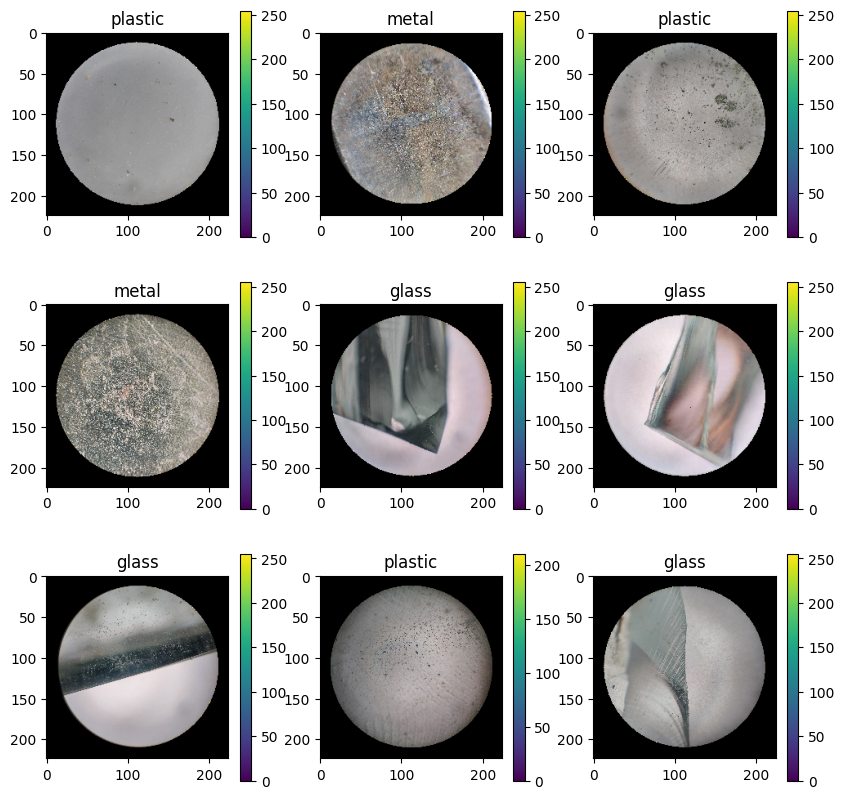

In [4]:
# 0 => glass
# 1 => plastic
# 2 => metal

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.colorbar()
    plt.axis("on")

#### Caching

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Augmentation

In [6]:
data_augmentation = Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(1),
])

In [7]:
num_classes = len(class_names)

from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, IMG_COLOR_CHANNEL))


# Create model
model = Sequential([
    data_augmentation,
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(num_classes, activation='softmax',name='predictions')
])

for layer in vgg_base.layers:
    layer.trainable = False
    
model.build(input_shape=(None,IMG_SIZE, IMG_SIZE,IMG_COLOR_CHANNEL))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 predictions (Dense)         (None, 3)                 771       
                                                                 
Total params: 21138243 (80.64 MB)
Trainable params: 6423555 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
checkpoint_callback = ModelCheckpoint("../models/best_model_weights.h5", monitor='val_loss', save_best_only=True, mode='min',verbose=1)
earlyStopping =tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=3,
    verbose=1,
    mode='auto',
    restore_best_weights=True,
    start_from_epoch=50
)
history = model.fit(train_ds, epochs=NUM_EPOCHS,
                    validation_data=val_ds,
                    callbacks=[checkpoint_callback])

Epoch 1/150
8/8 [==============================] - ETA: 0s - loss: 10.7207 - accuracy: 0.4875
Epoch 1: val_loss improved from inf to 7.37831, saving model to ../models/best_model_weights.h5
8/8 [==============================] - 11s 655ms/step - loss: 10.7207 - accuracy: 0.4875 - val_loss: 7.3783 - val_accuracy: 0.4167
Epoch 2/150


/Users/mehdirexon/PycharmProjects/Kharazmi/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - ETA: 0s - loss: 6.0609 - accuracy: 0.5750
Epoch 2: val_loss improved from 7.37831 to 2.22341, saving model to ../models/best_model_weights.h5
8/8 [==============================] - 3s 414ms/step - loss: 6.0609 - accuracy: 0.5750 - val_loss: 2.2234 - val_accuracy: 0.7667
Epoch 3/150
8/8 [==============================] - ETA: 0s - loss: 3.4170 - accuracy: 0.7458
Epoch 3: val_loss improved from 2.22341 to 1.89291, saving model to ../models/best_model_weights.h5
8/8 [==============================] - 3s 409ms/step - loss: 3.4170 - accuracy: 0.7458 - val_loss: 1.8929 - val_accuracy: 0.8333
Epoch 4/150
8/8 [==============================] - ETA: 0s - loss: 2.3196 - accuracy: 0.8417
Epoch 4: val_loss improved from 1.89291 to 1.87983, saving model to ../models/best_model_weights.h5
8/8 [==============================] - 3s 398ms/step - loss: 2.3196 - accuracy: 0.8417 - val_loss: 1.8798 - val_accuracy: 0.8333
Epoch 5/150
8/8 [=============================

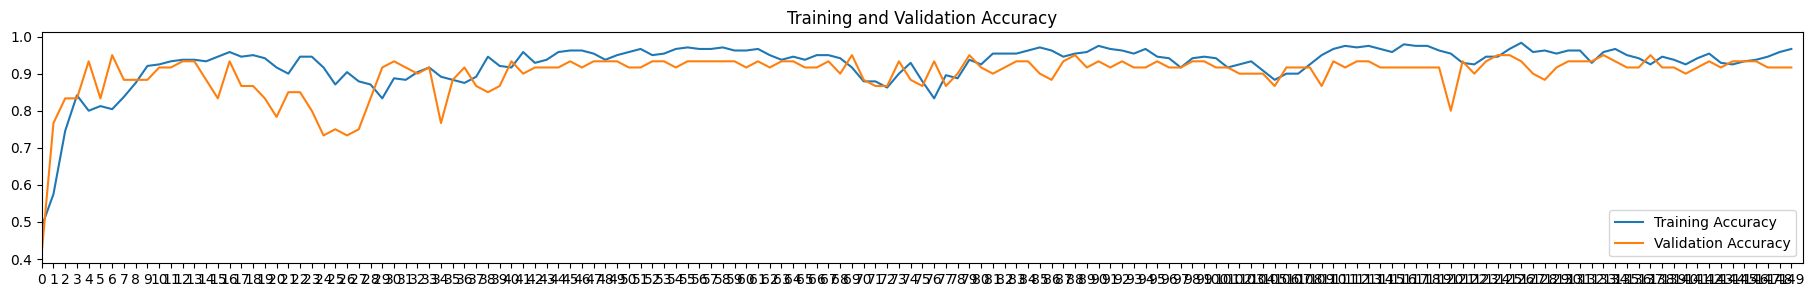

In [9]:
NUM_EPOCHS = len(history.history['loss'])
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']  

epochs_range = range(NUM_EPOCHS)
plt.figure(figsize=(50, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlim(0, NUM_EPOCHS)  # Set the x-axis limits
plt.xticks(epochs_range)  # Set the x-axis ticks
plt.show()

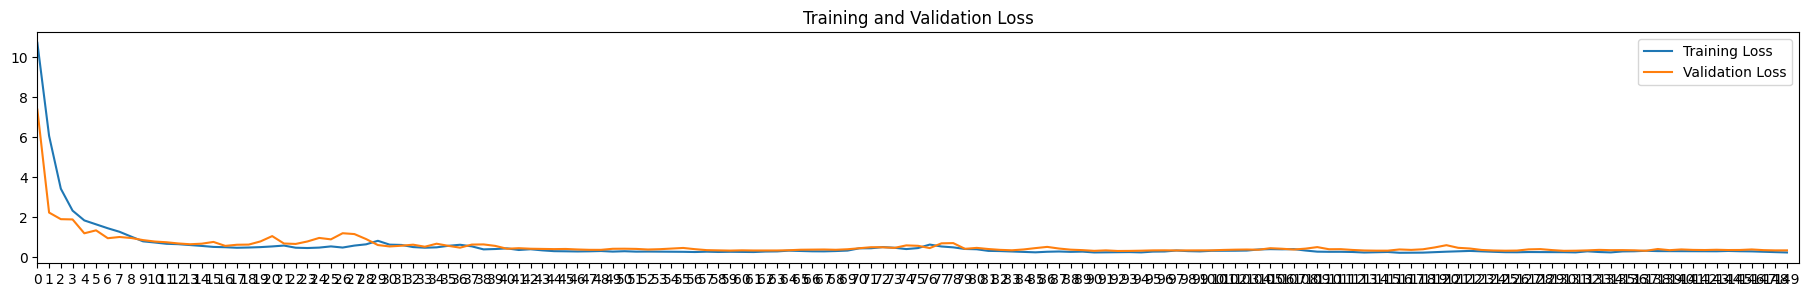

In [10]:
plt.figure(figsize=(50, 3))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlim(0, NUM_EPOCHS)  # Set the x-axis limits
plt.xticks(epochs_range)  # Set the x-axis ticks
plt.show()  

In [11]:
sunflower_path = "Unseen Data/plastic4.png"

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(IMG_SIZE, IMG_SIZE),color_mode=IMG_COLOR_MODE
)
img_array = tf.keras.utils.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)
predictions = model.predict(img_array)
print(predictions)
score = predictions[0]
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 273ms/step
[[0.19810633 0.00641691 0.7954767 ]]
This image most likely belongs to plastic with a 79.55 percent confidence.


In [12]:
model.load_weights("../models/best_model_weights.h5")

In [13]:
#model = tf.keras.models.load_model('../models/final_model.keras')

In [14]:
import sys
import numpy as np

def predictive_entropy(predictions):
    epsilon = sys.float_info.min
    predictive_entropy = -np.sum( np.mean(predictions, axis=0) * np.log(np.mean(predictions, axis=0) + epsilon),
            axis=-1)

    return predictive_entropy

In [15]:
def load_and_preprocess_image(image_path, target_size, color_mode):
    img = tf.keras.utils.load_img(
        image_path, target_size=target_size, color_mode=color_mode
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    return img_array

In [16]:
# sunflower_path = "Unseen Data/plastic2.png"
# 
# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=IMG_COLOR_MODE
# )
# img_array = tf.keras.utils.img_to_array(img)
# print(img_array.shape)
# img_array = tf.expand_dims(img_array, 0)  # Create a batch
# print(img_array.shape)
# predictions = model.predict(img_array)
# print(predictions)
# score = predictions[0]
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )
# confidence = score * 100  # Convert probabilities to percentages
# 
# # Color map for bars
# colors = plt.cm.viridis(np.linspace(0, 1, len(class_names)))
# 
# # Plotting
# plt.figure(figsize=(10, 6))
# bars = plt.barh(class_names, confidence, color=colors)
# 
# # Adding data labels
# for bar, conf in zip(bars, confidence):
#     plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{conf:.2f}%', va='center')
# 
# # Customizing aesthetics
# plt.xlabel('Confidence (%)', fontsize=12)
# plt.ylabel('Classes', fontsize=12)
# plt.title('Confidence Levels for Each Class', fontsize=14)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# 
# # Show the plot
# plt.gca().invert_yaxis()  # Invert y-axis to display classes from top to bottom
# plt.tight_layout()
# plt.show()

1/1 [==============================] - 0s 9ms/step


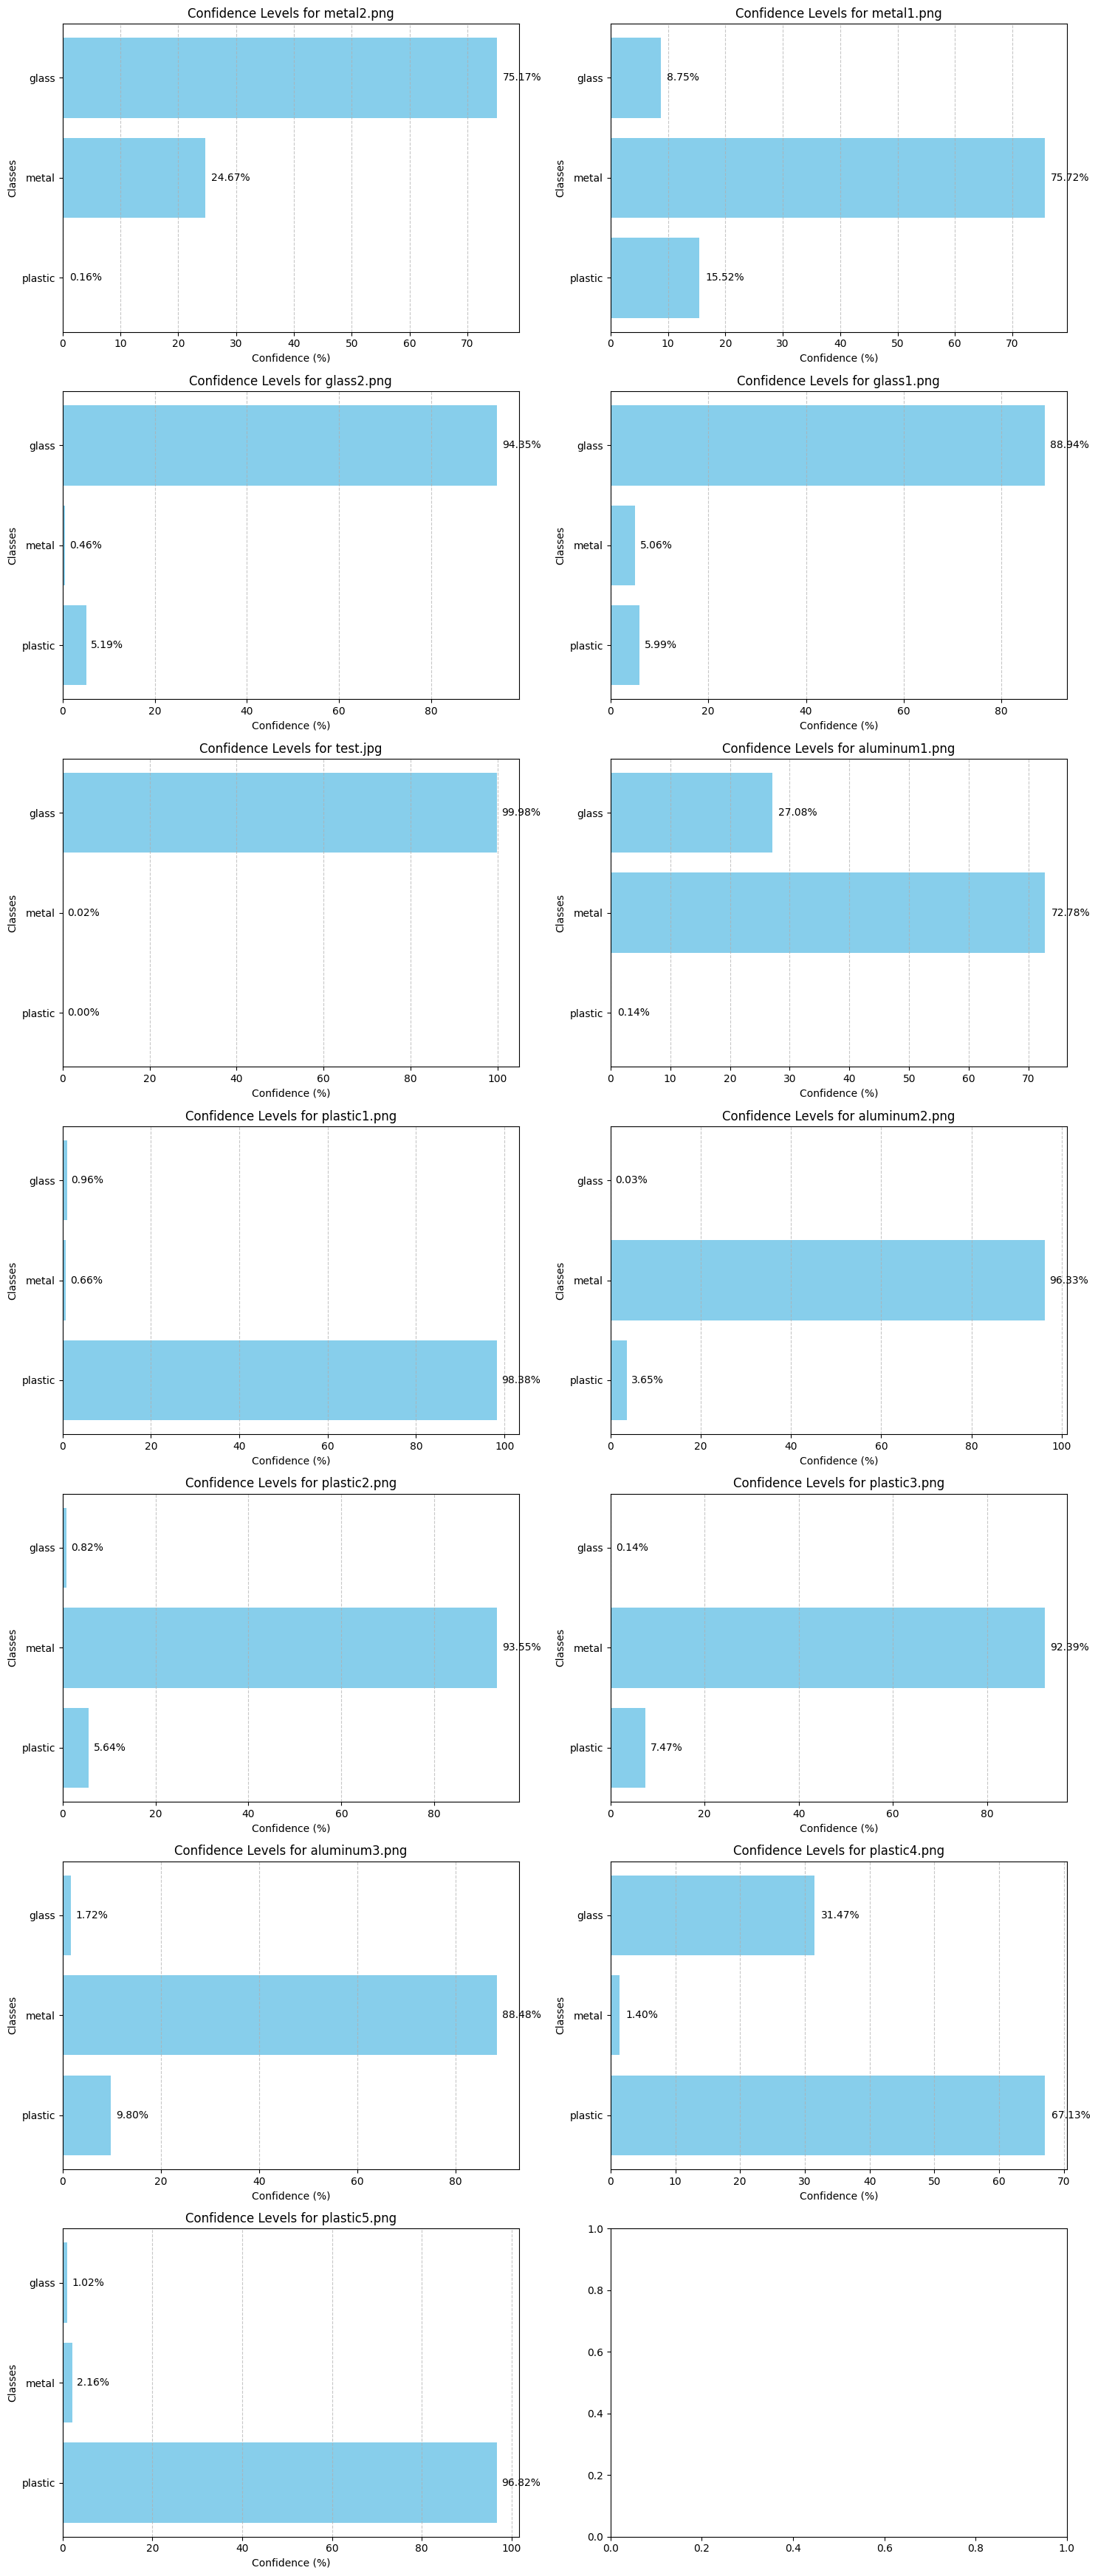

In [17]:

folder_path = "Unseen data/"

# List all files in the folder, filtering out non-image files
file_names = [file for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Number of rows and columns for subplots
num_images = len(file_names)
num_cols = 2
num_rows = (num_images + 1) // num_cols  # Add 1 to round up if necessary

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Load and make predictions for each image
for i, file_name in enumerate(file_names):
    image_path = os.path.join(folder_path, file_name)
    try:
        img_array = load_and_preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE), color_mode=IMG_COLOR_MODE)
        predictions = model.predict(img_array)
        score = predictions[0]

        # Prepare data for plotting
        confidence = score * 100  # Convert probabilities to percentages

        # Plotting
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col] if num_images > 1 else axs

        ax.barh(class_names, confidence, color='skyblue')

        # Adding data labels
        for bar, conf in zip(ax.patches, confidence):
            ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, f'{conf:.2f}%', va='center')

        # Customizing aesthetics
        ax.set_xlabel('Confidence (%)', fontsize=10)
        ax.set_ylabel('Classes', fontsize=10)
        ax.set_title(f'Confidence Levels for {file_name}', fontsize=12)
        ax.grid(axis='x', linestyle='--', alpha=0.7)

        ax.invert_yaxis()  # Invert y-axis to display classes from top to bottom

    except Exception as e:
        print(f"Error processing {file_name}: {e}")
        continue

# Adjust layout and show the plot
plt.tight_layout()
plt.show()